# Red Hot Chili Pepper Lyric Generation

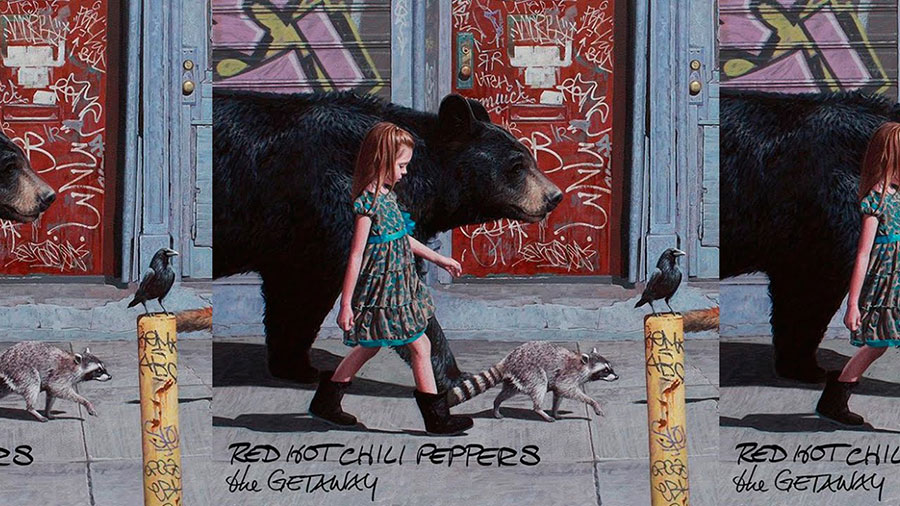

## Overview 
Use deep learning and machine learning to assist in the creation of new hit songs for the Red Hot Chili Peppers.

## Business Problem 
On average it take anywhere from 3-30 months to complete an album and I have come up with a solution to streamline this process and assist with the creation of new songs that can be used in upcoming albums. To accomplish this my goal is to use deep learning to generate new song lyrics that match your style and artistic voice. I will also use machine learning to predict the popularity score given the generated lyrics.

## Data 
To solve this problem, data on song lyrics and popuarity need to be collected. 
### Data Collection 
To collect song lyrics, lyricsgenius was used. Lyricsgenius is a python wrapper that utilizes the Genius lyrics API. Lyrics were collected for each song by album and artist name and saved to json files. A link to look at the notebook is [here](https://github.com/klsalcedo/lyric_generation/blob/main/misc_code/lyric_collection.ipynb).</p> 
<p>To collect data on song popularity, Spotipy - a python wrapper for Spotify's API - was used. Audio features like danceability, energy, key, loudness, speechiness, acousticness, liveness, instrumentalness, valence and tempo were collected along with populartiy. 

In [68]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import config
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import json
from function import *
import os 
import re
from nltk import word_tokenize
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.collocations import *
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(config.spotify['client_id'],
                                                                        config.spotify['client_secret']))

In [2]:
# uris were collected from Spotify
uris = ['spotify:album:43otFXrY0bgaq5fB3GrZj6','spotify:album:0fLhefnjlIV3pGNF9Wo8CD',
        'spotify:album:7xl50xr9NDkd3i2kBbzsNZ',
        'spotify:album:1jWKVgnHX8nwR551hQNx5K','spotify:album:1DCI2yWmV4UI7Aga71yx9B',
        'spotify:album:5wZtSIvijWCMc1vlPFqAyB','spotify:album:74cQBDmkkzRBntR064f0SD',
        'spotify:album:1oOkcBu5bgkUzZTvKD1m8z','spotify:album:3rHJQrfEcBeSaLPuLwKR6F',
        'spotify:album:10Oqhoq2akSJnurJOPk8xT']

rhcp = pd.DataFrame()

#looping through all uris to get songs and audio features 
for i in range(len(uris)):
    album = get_album_songs(uris[i])
    song = get_track_info(album)
    merged = album.merge(song, left_index=True, right_index=True)
    rhcp = rhcp.append(merged)
    
rhcp

,uri,track,duration_ms,explicit,track_number,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,spotify:track:3bIQIx7hveYPQDdhjZ1kcq,The Getaway,250386,False,1,0.797,0.642,0,-8.082,0.0725,0.079900,0.000012,0.3710,0.667,113.999
1,spotify:track:2oaK4JLVnmRGIO9ytBE1bt,Dark Necessities,302000,False,2,0.700,0.742,5,-6.777,0.0716,0.072200,0.019900,0.1100,0.197,91.959
2,spotify:track:0cv2LgkvEoQiGgFWcZaAMA,We Turn Red,200466,False,3,0.610,0.872,2,-5.428,0.0422,0.116000,0.147000,0.1520,0.842,164.038
3,spotify:track:0pjCkLjbgSLn5c0Ilwuv8z,The Longest Wave,211520,False,4,0.476,0.511,8,-6.250,0.0324,0.319000,0.000129,0.1190,0.339,148.158
4,spotify:track:2XTkpF9T2PKvcLgamGJGx1,Goodbye Angels,268733,False,5,0.365,0.804,9,-5.922,0.1050,0.104000,0.000066,0.1500,0.577,171.597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,spotify:track:5JF24LTcYhGxynXMSFkgm1,Yertle The Turtle - Remastered,226533,False,14,0.737,0.939,5,-5.101,0.0793,0.182000,0.000596,0.0707,0.964,92.519
14,spotify:track:3O0c4iSpL0VB230yLJCGUF,Nevermind,137040,True,15,0.667,0.900,8,-9.201,0.1500,0.013100,0.000000,0.0889,0.511,128.905
15,spotify:track:57U6Gt3GmNiUGvMOq8qxVn,Sex Rap,97226,True,16,0.658,0.863,11,-7.565,0.1120,0.040900,0.135000,0.3460,0.847,135.839
16,spotify:track:5zpQqzJeTUyLw5CYWzYM5t,Freaky Styley,529373,True,17,0.501,0.977,9,-5.421,0.0471,0.000559,0.721000,0.0573,0.876,96.796


In [3]:
#adding popularity column
add_popularity(rhcp)

#creading new index
x= len(rhcp['track'])
new_index = list(range(0,x))
rhcp['index'] = new_index
rhcp.set_index(['index'], inplace=True)

rhcp

,uri,track,duration_ms,explicit,track_number,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity
index,,,,,,,,,,,,,,,,
0,spotify:track:3bIQIx7hveYPQDdhjZ1kcq,The Getaway,250386,False,1,0.797,0.642,0,-8.082,0.0725,0.079900,0.000012,0.3710,0.667,113.999,62
1,spotify:track:2oaK4JLVnmRGIO9ytBE1bt,Dark Necessities,302000,False,2,0.700,0.742,5,-6.777,0.0716,0.072200,0.019900,0.1100,0.197,91.959,73
2,spotify:track:0cv2LgkvEoQiGgFWcZaAMA,We Turn Red,200466,False,3,0.610,0.872,2,-5.428,0.0422,0.116000,0.147000,0.1520,0.842,164.038,53
3,spotify:track:0pjCkLjbgSLn5c0Ilwuv8z,The Longest Wave,211520,False,4,0.476,0.511,8,-6.250,0.0324,0.319000,0.000129,0.1190,0.339,148.158,61
4,spotify:track:2XTkpF9T2PKvcLgamGJGx1,Goodbye Angels,268733,False,5,0.365,0.804,9,-5.922,0.1050,0.104000,0.000066,0.1500,0.577,171.597,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,spotify:track:5JF24LTcYhGxynXMSFkgm1,Yertle The Turtle - Remastered,226533,False,14,0.737,0.939,5,-5.101,0.0793,0.182000,0.000596,0.0707,0.964,92.519,52
162,spotify:track:3O0c4iSpL0VB230yLJCGUF,Nevermind,137040,True,15,0.667,0.900,8,-9.201,0.1500,0.013100,0.000000,0.0889,0.511,128.905,49
163,spotify:track:57U6Gt3GmNiUGvMOq8qxVn,Sex Rap,97226,True,16,0.658,0.863,11,-7.565,0.1120,0.040900,0.135000,0.3460,0.847,135.839,59


In [4]:
#creating lyric dataframe 
lyric_df = pd.DataFrame(columns=['track','album','lyrics','cleaned_lyrics'])

files = ['lyrics_data/Lyrics_TheGetaway.json','lyrics_data/Lyrics_Californication.json',
         'lyrics_data/Lyrics_BytheWay.json',
        'lyrics_data/Lyrics_BloodSugarSexMagik.json','lyrics_data/Lyrics_FreakyStyley.json',
        'lyrics_data/Lyrics_ImwithYou.json', 'lyrics_data/Lyrics_MothersMilk.json',
        'lyrics_data/Lyrics_OneHotMinute.json','lyrics_data/Lyrics_StadiumArcadium.json',
         'lyrics_data/Lyrics_TheUpliftMofoPartyPlan.json']

#looping through albums to extract song lyrics
for i in range(len(files)):
    with open(files[i]) as f:
        data = json.load(f)
    lyric_df = lyrics_to_df(data, lyric_df)
    
lyric_df

,track,album,lyrics,cleaned_lyrics
0,The Getaway,The Getaway,"[Verse 1: Anthony Kiedis]\nThat's right, you'r...",NaN
1,Dark Necessities,The Getaway,"[Verse 1]\nComin' on to the light of day, we g...",NaN
2,We Turn Red,The Getaway,[Intro]\nWe got large and we got small\nWe got...,NaN
3,The Longest Wave,The Getaway,[Verse 1]\nThrow me all around like a boomeran...,NaN
4,Goodbye Angels,The Getaway,[Verse 1]\nSuicide a month before I met you\nD...,NaN
...,...,...,...,...
165,Party on Your Pussy (aka Special Secret Song I...,The Uplift Mofo Party Plan,"[Verse 1]\nWell, my landlady, she lives\nThree...",NaN
166,No Chump Love Sucker,The Uplift Mofo Party Plan,"[Verse 1]\nShe's a witch, a brat, a bonafide b...",NaN
167,Walkin’ On Down The Road,The Uplift Mofo Party Plan,"[Verse 1]\nWell, I'm walkin' on down the road\...",NaN
168,Love Trilogy,The Uplift Mofo Party Plan,"[Verse 1]\nMy love comes, and when it does\nIt...",NaN


### Data Understanding 

In [5]:
#examining how lyrics data is structured 
lyric_df['lyrics'][0]

"[Verse 1: Anthony Kiedis]\nThat's right, you're right, we will do our thing tonight alright\nTake me through the future\nIt's time, you're fine, just another color coded crime\nIncision and a suture\nYou told my friend we would get it on no matter when\nA supercavitation\nLet's go, you show me something no one will ever know\nA love hallucination\n\n[Chorus: Anthony Kiedis]\nAnother lonely superstar to getaway inside your car\nTake it much too far\nSurrender to the brave inside a lover that another tried\nTake it, too my ride\n\n[Post-Chorus: Anthony Kiedis & Anna Waronker]\nYou don't have to keep it if it's mine\nAnother lonely superstar to getaway inside your car\nAnother place maybe another time\nSurrender to the brave inside a lover that another tried\n\n[Verse 2: Anthony Kiedis]\nComplete repeat sittin' in your car and on your street\nLost in California\nLet's steal this wheel, take a spin to find out how we feel\nJust around the corner\nSlow down for sound, turn it up and no we 

### Data Preparation
Before the lyrics can be run through models, they need to be tokenized. Before doing this there is some lyric cleaning that I'll preform. Words indicating song structure (i.e. verse, intro, chorus etc) along with '\n' indicating new lines were removed. Lyrics were also converted to all lowercase and punctuation removed. At the end of each song there is also embedded words - a result of how the data was collected - that also need to be removed. 

In [6]:
for i in range(len(lyric_df['lyrics'])):
    x = lyric_df['lyrics'][i]
    
    #removing last embedded word - URLCopyEmbedCopy
    x = x.replace('URLCopyEmbedCopy', ' ').replace(',','')
    
    #removing text in brackets 
    x = re.sub(r'[\(\[].*?[\)\]]', '', x)
    
    #removing [digits]EmbedShare
    x = re.sub('\d+\S*', '', x)
    
    #seperating lines (\n)
    x = os.linesep.join([s for s in x.splitlines() if s])
    
    #chaning all words to lowercase
    x = x.lower().split('\n')
    
    lyric_df['cleaned_lyrics'][i] = x
    
lyric_df.head()

,track,album,lyrics,cleaned_lyrics
0,The Getaway,The Getaway,"[Verse 1: Anthony Kiedis]\nThat's right, you'r...",[that's right you're right we will do our thin...
1,Dark Necessities,The Getaway,"[Verse 1]\nComin' on to the light of day, we g...","[comin' on to the light of day we got, many mo..."
2,We Turn Red,The Getaway,[Intro]\nWe got large and we got small\nWe got...,"[we got large and we got small, we got a swimm..."
3,The Longest Wave,The Getaway,[Verse 1]\nThrow me all around like a boomeran...,"[throw me all around like a boomerang sky, wha..."
4,Goodbye Angels,The Getaway,[Verse 1]\nSuicide a month before I met you\nD...,"[suicide a month before i met you, deep regret..."


In [7]:
#checking first 5 lines
lyric_df['cleaned_lyrics'][0][:5]

["that's right you're right we will do our thing tonight alright",
 'take me through the future',
 "it's time you're fine just another color coded crime",
 'incision and a suture',
 'you told my friend we would get it on no matter when']

The two datasets can now be merged together on the 'track' column.

In [8]:
rhcp = pd.merge(rhcp, lyric_df, on=['track'])
rhcp.head()

,uri,track,duration_ms,explicit,track_number,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,album,lyrics,cleaned_lyrics
0,spotify:track:3bIQIx7hveYPQDdhjZ1kcq,The Getaway,250386,False,1,0.797,0.642,0,-8.082,0.0725,0.0799,0.000012,0.371,0.667,113.999,62,The Getaway,"[Verse 1: Anthony Kiedis]\nThat's right, you'r...",[that's right you're right we will do our thin...
1,spotify:track:2oaK4JLVnmRGIO9ytBE1bt,Dark Necessities,302000,False,2,0.700,0.742,5,-6.777,0.0716,0.0722,0.019900,0.110,0.197,91.959,73,The Getaway,"[Verse 1]\nComin' on to the light of day, we g...","[comin' on to the light of day we got, many mo..."
2,spotify:track:0cv2LgkvEoQiGgFWcZaAMA,We Turn Red,200466,False,3,0.610,0.872,2,-5.428,0.0422,0.1160,0.147000,0.152,0.842,164.038,53,The Getaway,[Intro]\nWe got large and we got small\nWe got...,"[we got large and we got small, we got a swimm..."
3,spotify:track:0pjCkLjbgSLn5c0Ilwuv8z,The Longest Wave,211520,False,4,0.476,0.511,8,-6.250,0.0324,0.3190,0.000129,0.119,0.339,148.158,61,The Getaway,[Verse 1]\nThrow me all around like a boomeran...,"[throw me all around like a boomerang sky, wha..."
4,spotify:track:2XTkpF9T2PKvcLgamGJGx1,Goodbye Angels,268733,False,5,0.365,0.804,9,-5.922,0.1050,0.1040,0.000066,0.150,0.577,171.597,63,The Getaway,[Verse 1]\nSuicide a month before I met you\nD...,"[suicide a month before i met you, deep regret..."


### Data Cleaning
To get the lyric data into acceptable format that can be used in machine learning models it first needs to be tokenized. 

In [9]:
#pattern used to tokenize each word 
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

rhcp['tokenized_lyrics_raw'] = None 

for song in range(len(rhcp['cleaned_lyrics'])):
    lyrics = rhcp['cleaned_lyrics'][song]
    tokens = []
    for sentence in range(len(lyrics)):
        token = nltk.regexp_tokenize(lyrics[sentence], pattern)
        tokens.append(token)
    rhcp['tokenized_lyrics_raw'][song] = tokens    

rhcp.head()

,uri,track,duration_ms,explicit,track_number,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,album,lyrics,cleaned_lyrics,tokenized_lyrics_raw
0,spotify:track:3bIQIx7hveYPQDdhjZ1kcq,The Getaway,250386,False,1,0.797,0.642,0,-8.082,0.0725,0.0799,0.000012,0.371,0.667,113.999,62,The Getaway,"[Verse 1: Anthony Kiedis]\nThat's right, you'r...",[that's right you're right we will do our thin...,"[[that's, right, you're, right, we, will, do, ..."
1,spotify:track:2oaK4JLVnmRGIO9ytBE1bt,Dark Necessities,302000,False,2,0.700,0.742,5,-6.777,0.0716,0.0722,0.019900,0.110,0.197,91.959,73,The Getaway,"[Verse 1]\nComin' on to the light of day, we g...","[comin' on to the light of day we got, many mo...","[[comin, on, to, the, light, of, day, we, got]..."
2,spotify:track:0cv2LgkvEoQiGgFWcZaAMA,We Turn Red,200466,False,3,0.610,0.872,2,-5.428,0.0422,0.1160,0.147000,0.152,0.842,164.038,53,The Getaway,[Intro]\nWe got large and we got small\nWe got...,"[we got large and we got small, we got a swimm...","[[we, got, large, and, we, got, small], [we, g..."
3,spotify:track:0pjCkLjbgSLn5c0Ilwuv8z,The Longest Wave,211520,False,4,0.476,0.511,8,-6.250,0.0324,0.3190,0.000129,0.119,0.339,148.158,61,The Getaway,[Verse 1]\nThrow me all around like a boomeran...,"[throw me all around like a boomerang sky, wha...","[[throw, me, all, around, like, a, boomerang, ..."
4,spotify:track:2XTkpF9T2PKvcLgamGJGx1,Goodbye Angels,268733,False,5,0.365,0.804,9,-5.922,0.1050,0.1040,0.000066,0.150,0.577,171.597,63,The Getaway,[Verse 1]\nSuicide a month before I met you\nD...,"[suicide a month before i met you, deep regret...","[[suicide, a, month, before, i, met, you], [de..."


Looking at the datatype of the 'tokenized_lyrics_raw' column, it is a nested list. I will create a new column 'tokenized lyrics' to unnest the data and drop the 'tokenized_lyrics_raw' column.

In [10]:
rhcp['tokenized_lyrics'] = None 

for i in range(len(rhcp['tokenized_lyrics_raw'])):
    corpus = []
    song = rhcp['tokenized_lyrics_raw'][i]
    for x in range(len(song)):
        sentence = song[x]
        for y in range(len(sentence)):
            word = sentence[y]
            corpus.append(word)
    rhcp['tokenized_lyrics'][i] = corpus

rhcp = rhcp.drop(columns=['tokenized_lyrics_raw'], axis=1)

rhcp.head()

,uri,track,duration_ms,explicit,track_number,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,album,lyrics,cleaned_lyrics,tokenized_lyrics
0,spotify:track:3bIQIx7hveYPQDdhjZ1kcq,The Getaway,250386,False,1,0.797,0.642,0,-8.082,0.0725,0.0799,0.000012,0.371,0.667,113.999,62,The Getaway,"[Verse 1: Anthony Kiedis]\nThat's right, you'r...",[that's right you're right we will do our thin...,"[that's, right, you're, right, we, will, do, o..."
1,spotify:track:2oaK4JLVnmRGIO9ytBE1bt,Dark Necessities,302000,False,2,0.700,0.742,5,-6.777,0.0716,0.0722,0.019900,0.110,0.197,91.959,73,The Getaway,"[Verse 1]\nComin' on to the light of day, we g...","[comin' on to the light of day we got, many mo...","[comin, on, to, the, light, of, day, we, got, ..."
2,spotify:track:0cv2LgkvEoQiGgFWcZaAMA,We Turn Red,200466,False,3,0.610,0.872,2,-5.428,0.0422,0.1160,0.147000,0.152,0.842,164.038,53,The Getaway,[Intro]\nWe got large and we got small\nWe got...,"[we got large and we got small, we got a swimm...","[we, got, large, and, we, got, small, we, got,..."
3,spotify:track:0pjCkLjbgSLn5c0Ilwuv8z,The Longest Wave,211520,False,4,0.476,0.511,8,-6.250,0.0324,0.3190,0.000129,0.119,0.339,148.158,61,The Getaway,[Verse 1]\nThrow me all around like a boomeran...,"[throw me all around like a boomerang sky, wha...","[throw, me, all, around, like, a, boomerang, s..."
4,spotify:track:2XTkpF9T2PKvcLgamGJGx1,Goodbye Angels,268733,False,5,0.365,0.804,9,-5.922,0.1050,0.1040,0.000066,0.150,0.577,171.597,63,The Getaway,[Verse 1]\nSuicide a month before I met you\nD...,"[suicide a month before i met you, deep regret...","[suicide, a, month, before, i, met, you, deep,..."


Next I will remove stop words along with other words commonly found in lyrics like nah, la, ah, oh and so on.

In [11]:
stopwords_list = stopwords.words('english')
rhcp['stopped_lyrics'] = None

for i in range(len(rhcp['tokenized_lyrics'])):
    tokens = rhcp['tokenized_lyrics'][i]
    stopped = [w for w in tokens if w not in stopwords_list and w not in ['na','la', 'nah', 'ah',
                                                                          'oh', "i'm","i've","i'll"]]
    rhcp['stopped_lyrics'][i] = stopped
    
rhcp.head(3)

,uri,track,duration_ms,explicit,track_number,danceability,energy,key,loudness,speechiness,...,instrumentalness,liveness,valence,tempo,popularity,album,lyrics,cleaned_lyrics,tokenized_lyrics,stopped_lyrics
0,spotify:track:3bIQIx7hveYPQDdhjZ1kcq,The Getaway,250386,False,1,0.797,0.642,0,-8.082,0.0725,...,0.000012,0.371,0.667,113.999,62,The Getaway,"[Verse 1: Anthony Kiedis]\nThat's right, you'r...",[that's right you're right we will do our thin...,"[that's, right, you're, right, we, will, do, o...","[that's, right, right, thing, tonight, alright..."
1,spotify:track:2oaK4JLVnmRGIO9ytBE1bt,Dark Necessities,302000,False,2,0.700,0.742,5,-6.777,0.0716,...,0.019900,0.110,0.197,91.959,73,The Getaway,"[Verse 1]\nComin' on to the light of day, we g...","[comin' on to the light of day we got, many mo...","[comin, on, to, the, light, of, day, we, got, ...","[comin, light, day, got, many, moons, deep, pl..."
2,spotify:track:0cv2LgkvEoQiGgFWcZaAMA,We Turn Red,200466,False,3,0.610,0.872,2,-5.428,0.0422,...,0.147000,0.152,0.842,164.038,53,The Getaway,[Intro]\nWe got large and we got small\nWe got...,"[we got large and we got small, we got a swimm...","[we, got, large, and, we, got, small, we, got,...","[got, large, got, small, got, swimming, pool, ..."


## Exploritory Data Analysis 
### Lyrics

In [12]:
#creating corpus of tokens from all songs
rhcp_lyrics_stopped = []
for i in range(len(rhcp['stopped_lyrics'])):
    song = rhcp['stopped_lyrics'][i]
    for x in range(len(song)):
        word = song[x]
        rhcp_lyrics_stopped.append(word)
        
print('Total Tokens: %d' % len(rhcp_lyrics_stopped))
print('Unique Tokens: %d' % len(set(rhcp_lyrics_stopped)))

Total Tokens: 17177
Unique Tokens: 3606


Out of 118 songs there are a total of 3606 unique words.

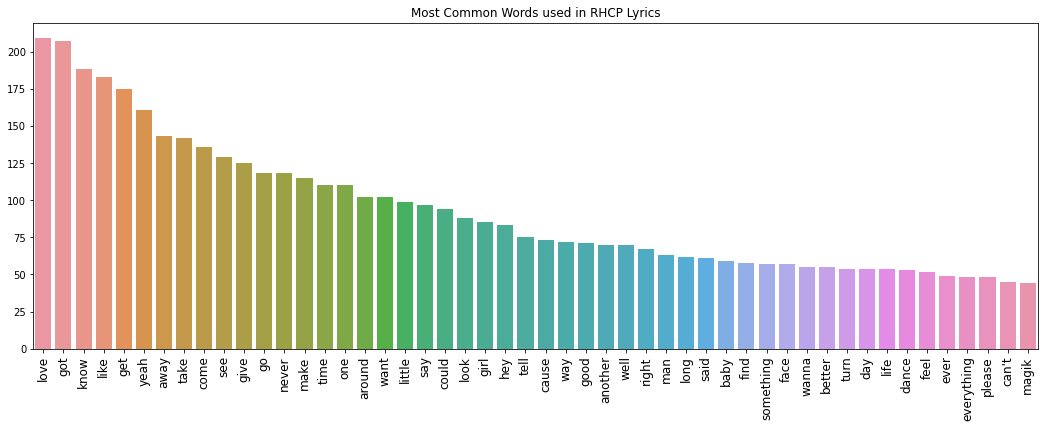

In [13]:
#graphing 50 most common words
word_counts = Counter(rhcp_lyrics_stopped)
common_words = [word[0] for word in word_counts.most_common(50)]
common_counts = [word[1] for word in word_counts.most_common(50)]

plt.figure(figsize=(18, 6))
sns.barplot(x=common_words, y=common_counts)
plt.title("Most Common Words used in RHCP Lyrics")
plt.xticks(rotation=90, fontsize=12)
plt.show()

The 50 most common words are shown above. The most used word is love.

In [14]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
rhcp_finder = BigramCollocationFinder.from_words(rhcp_lyrics_stopped)
rhcp_scored = rhcp_finder.score_ngrams(bigram_measures.raw_freq)
rhcp_scored[:50]

[(('give', 'away'), 0.004075216859754323),
 (('away', 'give'), 0.0036676951737788905),
 (('yeah', 'yeah'), 0.0023286953484310414),
 (('sex', 'magik'), 0.0018629562787448332),
 (('dance', 'dance'), 0.001746521511323281),
 (('ayo', 'ayo'), 0.001630086743901729),
 (('magik', 'sex'), 0.001630086743901729),
 (('em', 'see'), 0.0012807824416370729),
 (('fuck', 'em'), 0.0012807824416370729),
 (('got', 'got'), 0.0012807824416370729),
 (('look', 'face'), 0.0012807824416370729),
 (('see', 'look'), 0.0012807824416370729),
 (('good', 'god'), 0.001222565057926297),
 (('lay', 'lay'), 0.001222565057926297),
 (('see', 'around'), 0.001222565057926297),
 (('aah', 'aah'), 0.0011643476742155207),
 (('cabron', 'cabron'), 0.0011643476742155207),
 (('face', 'fuck'), 0.0011643476742155207),
 (('see', 'gettin'), 0.0011643476742155207),
 (('come', 'get'), 0.0011061302905047447),
 (('like', 'dirt'), 0.0011061302905047447),
 (('look', 'around'), 0.0011061302905047447),
 (('one', 'big'), 0.0010479129067939687),
 ((

Above shows the frequency of word pairs found in the corpus. Of these 'give away' and 'yeah yeah' were in the top 3.

### Audio Features

In [15]:
top_5 = rhcp.sort_values(by=['popularity'], ascending=False)
top_5.head()

,uri,track,duration_ms,explicit,track_number,danceability,energy,key,loudness,speechiness,...,instrumentalness,liveness,valence,tempo,popularity,album,lyrics,cleaned_lyrics,tokenized_lyrics,stopped_lyrics
93,spotify:track:41DpvNasaZdQzQqQYntd0o,Aeroplane,285066,True,2,0.639,0.839,5,-4.703,0.0634,...,0.000004,0.4680,0.603,101.447,73,One Hot Minute,[Chorus]\nI like pleasure spiked with pain\nAn...,"[i like pleasure spiked with pain, and music i...","[i, like, pleasure, spiked, with, pain, and, m...","[like, pleasure, spiked, pain, music, aeroplan..."
66,spotify:track:5guVvrqQlZVTnHky6gxVOP,If You Have to Ask,216693,True,2,0.709,0.738,7,-12.019,0.0480,...,0.795000,0.0730,0.671,96.240,73,Blood Sugar Sex Magik,[Verse 1]\nA wanna be gangster thinkin' he's a...,"[a wanna be gangster thinkin' he's a wise guy,...","[a, wanna, be, gangster, thinkin, he's, a, wis...","[wanna, gangster, thinkin, he's, wise, guy, ro..."
28,spotify:track:2aibwv5hGXSgw7Yru8IYTO,Snow (Hey Oh),334666,False,2,0.427,0.900,11,-3.674,0.0499,...,0.000017,0.1190,0.599,104.655,73,Stadium Arcadium,[Verse 1: Anthony Kiedis]\nCome to decide that...,"[come to decide that the things that i tried, ...","[come, to, decide, that, the, things, that, i,...","[come, decide, things, tried, life, get, high,..."
14,spotify:track:3ZwxczCIlt4nA7czQaugvM,Parallel Universe,269373,False,2,0.344,0.984,0,-2.350,0.2200,...,0.268000,0.0741,0.192,124.376,73,Californication,[Verse 1]\nDeep inside of a parallel universe\...,"[deep inside of a parallel universe, it's gett...","[deep, inside, of, a, parallel, universe, it's...","[deep, inside, parallel, universe, getting, ha..."
52,spotify:track:41Zn87ZIdgv7JVKBBPCnXg,Universally Speaking,256959,False,2,0.558,0.924,2,-2.312,0.0367,...,0.003260,0.2630,0.344,117.111,73,By the Way,[Verse 1]\nI saw your face elegant and tired\n...,"[i saw your face elegant and tired, cut up fro...","[i, saw, your, face, elegant, and, tired, cut,...","[saw, face, elegant, tired, cut, chase, still,..."


Above shows the top 5 most popular songs. They include Funky Crime, If You Have to Ask, Dark Necesseties, Snow and Aeroplane. These songs all scored 73 in popularity and all come from different albums. 

Next, I'll look at the distrubution and spread of the data. This will help give an understanding of the data for regression modeling. 

In [16]:
rhcp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 0 to 117
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uri               118 non-null    object 
 1   track             118 non-null    object 
 2   duration_ms       118 non-null    int64  
 3   explicit          118 non-null    bool   
 4   track_number      118 non-null    int64  
 5   danceability      118 non-null    float64
 6   energy            118 non-null    float64
 7   key               118 non-null    int64  
 8   loudness          118 non-null    float64
 9   speechiness       118 non-null    float64
 10  acousticness      118 non-null    float64
 11  instrumentalness  118 non-null    float64
 12  liveness          118 non-null    float64
 13  valence           118 non-null    float64
 14  tempo             118 non-null    float64
 15  popularity        118 non-null    int64  
 16  album             118 non-null    object 
 1

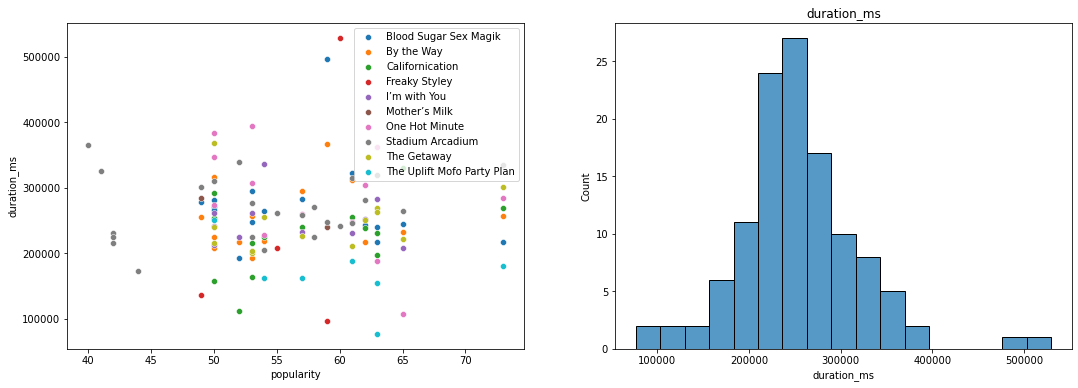

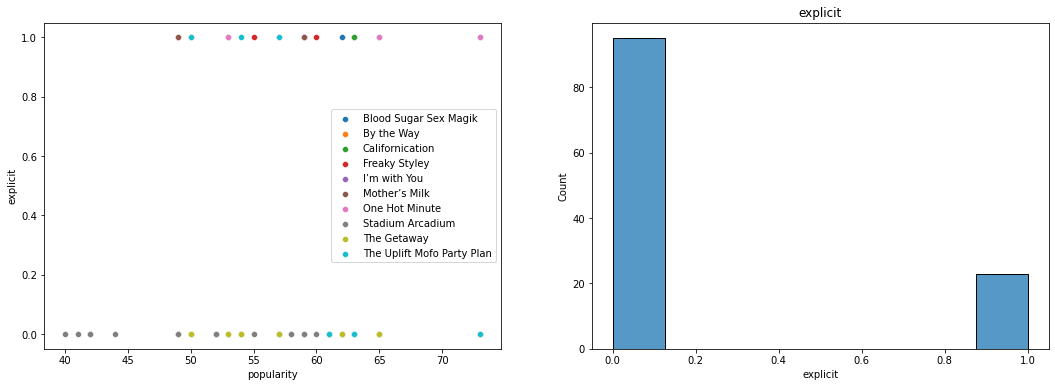

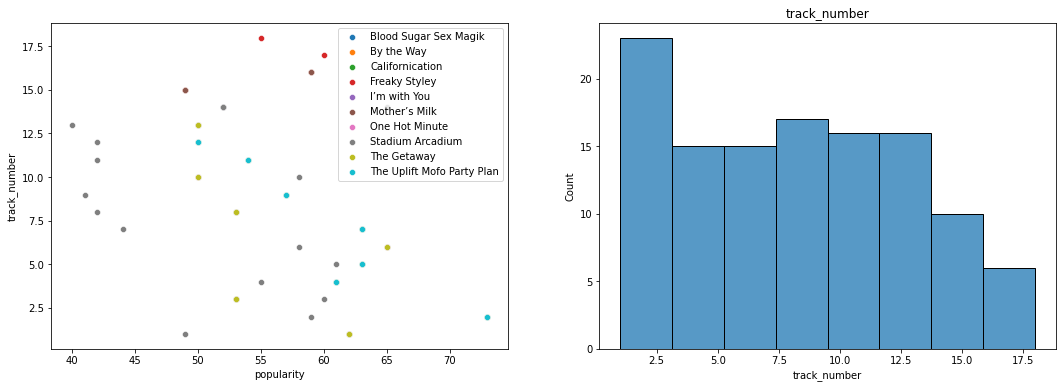

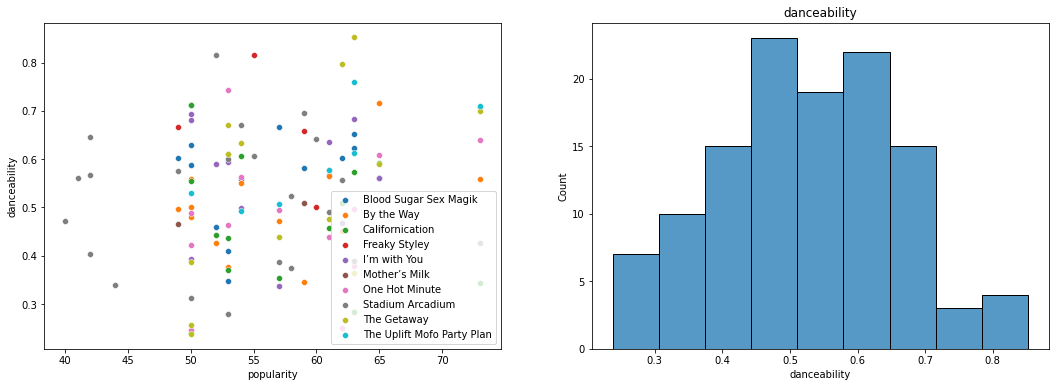

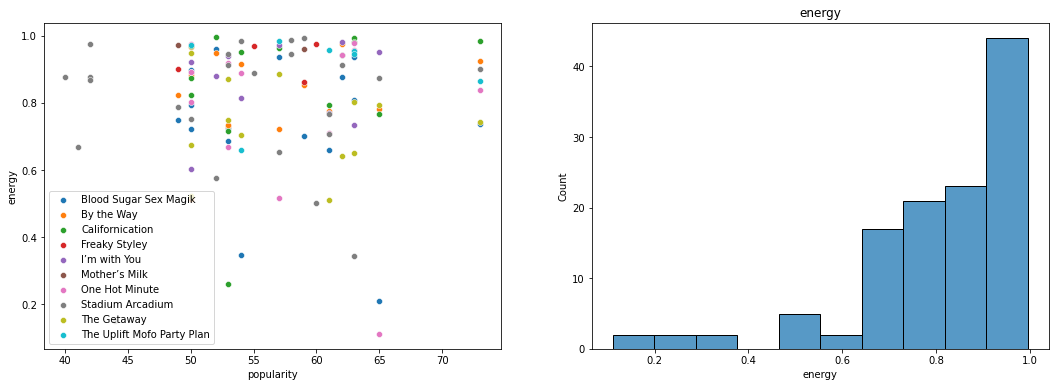

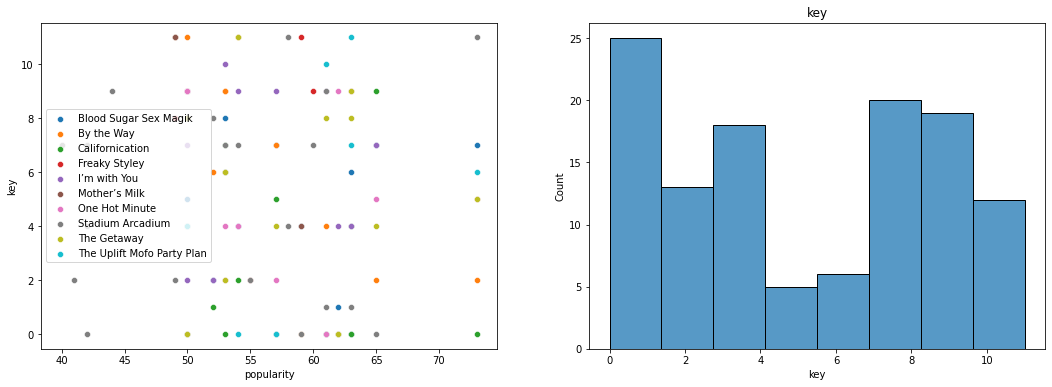

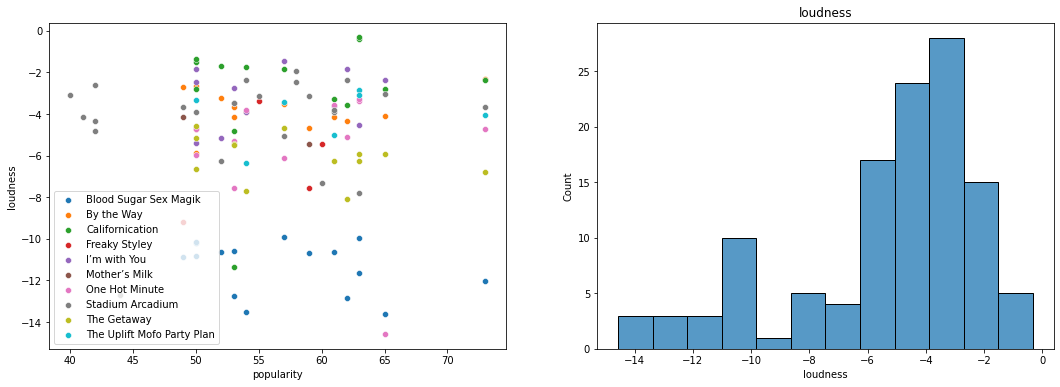

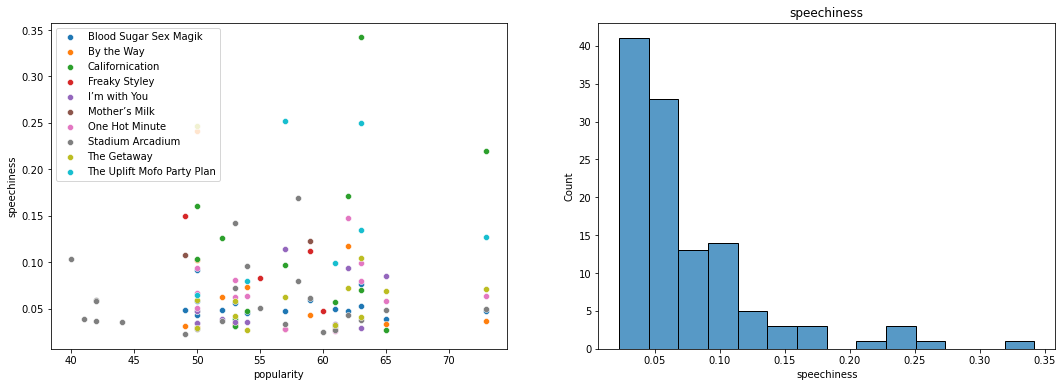

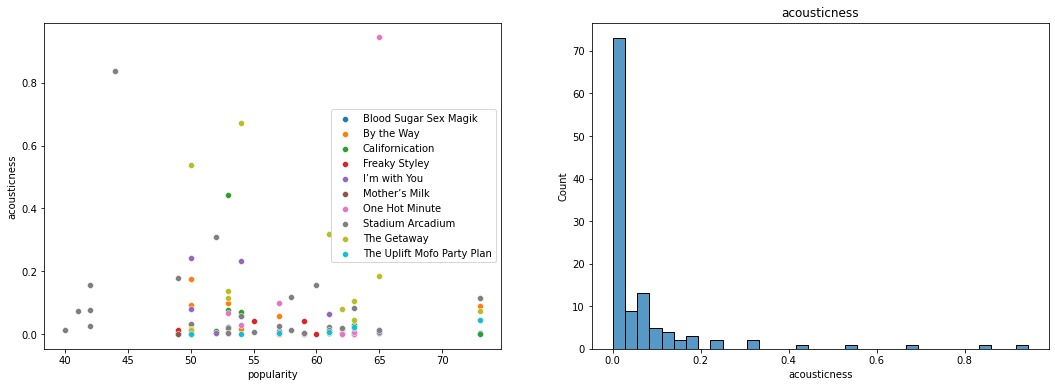

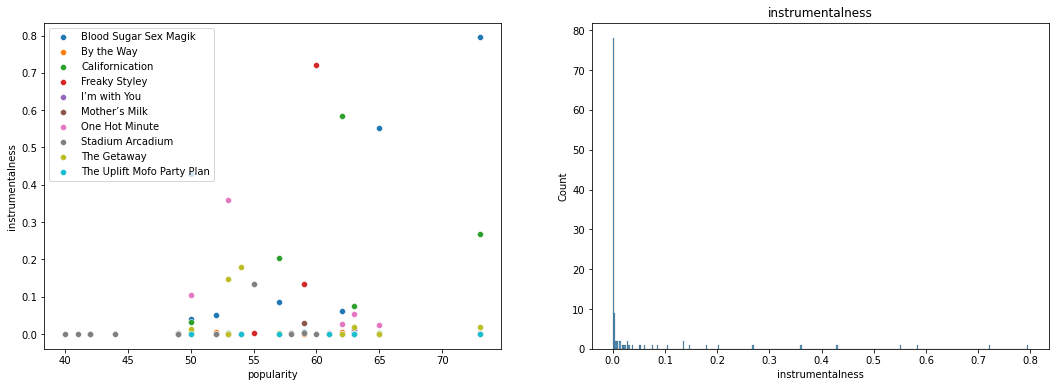

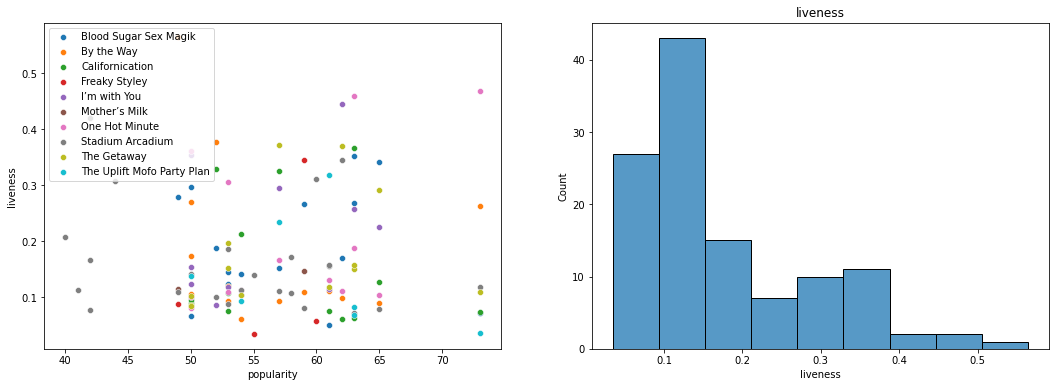

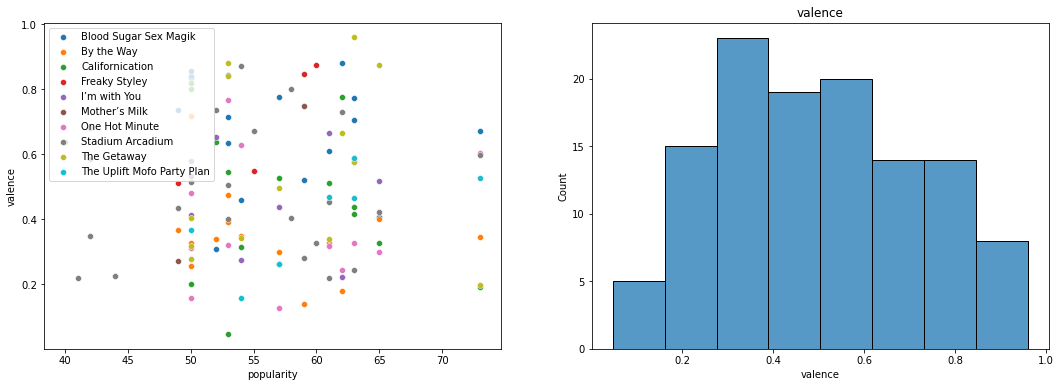

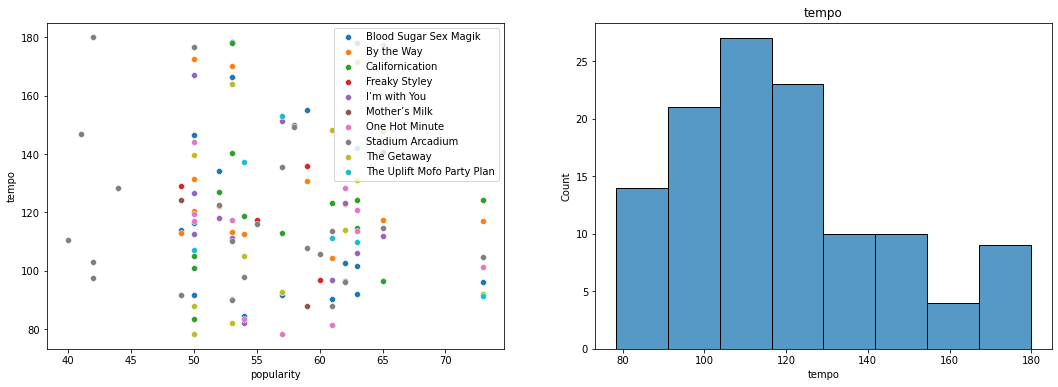

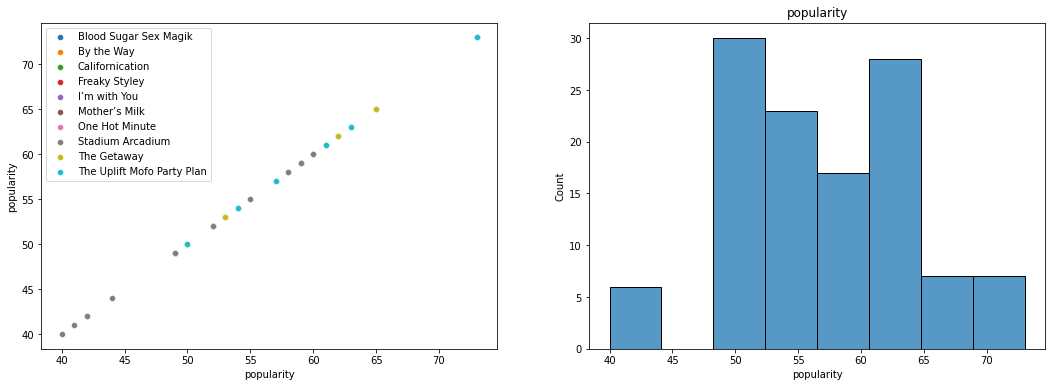

In [17]:
grouped = rhcp.groupby('album')
cont_var = rhcp.select_dtypes(exclude='object').columns

for column in cont_var:
    fix, ax = plt.subplots(1,2, figsize=(18,6))
    for name, group in grouped:
        sns.scatterplot(x=group['popularity'], y=group[column], label=name, ax=ax[0])
    sns.histplot(data=rhcp, x=column, ax=ax[1])
    plt.title(column)
    plt.show()

<p>From the plots above, features that are relatively normally distrubuted are: duration_ms, danceability and valence. Variables that show a skew (either left or right) include: energy, loudness, speechless, acoustiness, instrumentalness, liveness and tempo. Based on this info, it could be beneficial to normalize the data prior to modeling. </p>
<p> Looking at the distubution of popularity, most of the RHCP scores are between 50-65 with some outliers around 40 and 70. This could affect well the language model preforms/learns and could affect the regression model. 

## Language Model Designing
To generate song lyrics, I'll develop a statistical language model that utilizes deep learning. This language model will be able to predict the probabiity of the next word in the sequence given an input sequence. 

In [18]:
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import models, layers
from keras.models import load_model
from pickle import load
from keras.callbacks import EarlyStopping

In [19]:
#creating corpus of all sentences 
sentence_tokens = []
for song in range(len(rhcp)):
    lyrics = rhcp['cleaned_lyrics'][song]
    for lyric in rhcp['cleaned_lyrics'][song]:
        sentence_tokens.append(lyric)

sentence_tokens[:5]

["that's right you're right we will do our thing tonight alright",
 'take me through the future',
 "it's time you're fine just another color coded crime",
 'incision and a suture',
 'you told my friend we would get it on no matter when']

In [20]:
print('Total Tokens: %d' % len(sentence_tokens))
print('Unique Tokens: %d' % len(set(sentence_tokens)))

Total Tokens: 5166
Unique Tokens: 3493


In [21]:
#removing repeated lines
sentence_tokens = list(set(sentence_tokens))

#creating tokens for each word 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentence_tokens)


total_words = len(tokenizer.word_index) + 1
total_words

3813

The resulting dictionary represent all the words in the corpus with the value of each key being the index.

In [22]:
#create input sequences fro list of tokens
input_seq = []

for line in sentence_tokens:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1,len(token_list)):
        ngram_seq = token_list[:i+1]
        input_seq.append(ngram_seq)
        
input_seq[:5]

[[132, 8],
 [132, 8, 1],
 [132, 8, 1, 413],
 [132, 8, 1, 413, 786],
 [132, 8, 1, 413, 786, 8]]

Input sequences are the numerical representation of how the words in each line are arranged. For example, the first array in input_seq is [17, 7]. Referring to the tokenizer.word_index, number 17 represents the word 'all' and 7 represents 'my'. Looking at the input_seq, there are different input sequences for the same sentence that vary in length. It is a representation of how the model learns, so given the first word it will predict the second and given the first two words it will try to predict the third and so on. Since not every sentence in the corpus is the same length, I will use pad_sequences to solve this. Padding will ensure all sentences are the same length by filling in the blancks with zeros.

In [23]:
max_length = max([len(x) for x in input_seq])
input_seq = np.array(pad_sequences(input_seq, maxlen=max_length, padding='pre'))
input_seq

array([[  0,   0,   0, ...,   0, 132,   8],
       [  0,   0,   0, ..., 132,   8,   1],
       [  0,   0,   0, ...,   8,   1, 413],
       ...,
       [  0,   0,   0, ...,  53,   7, 409],
       [  0,   0,   0, ...,   7, 409,   9],
       [  0,   0,   0, ..., 409,   9, 865]], dtype=int32)

Because this is a supervised learning problem, we need to provide the model with labels so that it can generalize the relationship between the input words and the predicted words.

In [24]:
predictors, label = input_seq[:,:-1], input_seq[:,-1]
label = to_categorical(label, num_classes=total_words)
seq_length = predictors.shape[1]

## Neural Language Modeling 

To generate songs I used an LSTM network or a long short term memory which is a type of rnn that has feedback connections. It is capable of learning order dependence in sequence prediction which makes it a good model for text generation because it learns the sentence/line structure and how each word is being arranged to build new sentences.</p>
The model was run in a different notebook that can be found [here](https://github.com/klsalcedo/lyric_generation/blob/main/misc_code/lyric_analysis.ipynb) under the heading 'Neural Language Model'. It was trained on 409,213 parameters and run for 100 epochs. It started with an accuracy of 0.03 and loss 0f 6.57 and after 100 epochs it currently has an accuracy of 0.49 and loss of 2.05, which is pretty good considering that 100% accuracy would mean the model is memorizing the text. An accuracy score of 49% means that the model is 49% accurate of predicting the next word, which is enough to capture the essense of the text and allow for some variation/generalization.


The model was saved under 'model.h5'.

In [25]:
model = load_model('model.h5')
tokenizer = load(open('tokenizer.pkl', 'rb'))

To improve upon the model, I want to try using pre trained networks - textgenrnn.

## Lyric Generation

In [26]:
def make_lyrics(seed_txt, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_txt])[0]
        token_list = pad_sequences([token_list], maxlen=seq_length, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_txt += " " + output_word
    return seed_txt

The function above is taking the input, or seed, text tokenizing and padding it. The model then uses the seed text to predict an index number for the next word/words. This is looped through the number of times indicated by 'next_words'.

In [29]:
make_lyrics('whatever', 25)

"whatever happened to humanity rooms under coast to growl her off my bonnie and let's knock the parking lot of the daughter of touch me all"

In [30]:
make_lyrics('hello', 4)

'hello young brothers in your'

The lyrics seem to make better sense when the model predicts shorter sentences. I will create part of a song using the model to predict the next 4-7 words given the first. 

In [31]:
inputs = ['you', 'but', "ain't", 'mountains', 'we', 'the', 'beautiful', 'baby', "don't", 'okay']
num = [6,5,7,5,6,4,5,7,6,4]

new_song = []

for word, n in zip(inputs, num):
    lyrics = make_lyrics(word, n)
    new_song.append(lyrics)

new_song

['you can kick my face for pop',
 "but i can't contain me i",
 "ain't up i am okay snow on the",
 "mountains i can't complain in the",
 'we are the ones that will make',
 'the world i really find',
 "beautiful around i'll wait for you",
 "baby oughta celebrate you can't torture me please",
 "don't forsake me i'm contagious than fine",
 'okay its stated sweep solitaire']

## Regression Modeling 

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, SGDRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

I will now build the regression model to predict audio features and popularity based off the lyrics.

In [33]:
#dropping unnecessary columns from dataset
rhcp_reg = rhcp.drop(columns=['explicit', 'album', 'track', 'uri',
                              'tokenized_lyrics', 'cleaned_lyrics',
                              'track_number','lyrics','explicit'], axis=1)
rhcp_reg.head()

,duration_ms,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,stopped_lyrics
0,250386,0.797,0.642,0,-8.082,0.0725,0.0799,0.000012,0.371,0.667,113.999,62,"[that's, right, right, thing, tonight, alright..."
1,302000,0.700,0.742,5,-6.777,0.0716,0.0722,0.019900,0.110,0.197,91.959,73,"[comin, light, day, got, many, moons, deep, pl..."
2,200466,0.610,0.872,2,-5.428,0.0422,0.1160,0.147000,0.152,0.842,164.038,53,"[got, large, got, small, got, swimming, pool, ..."
3,211520,0.476,0.511,8,-6.250,0.0324,0.3190,0.000129,0.119,0.339,148.158,61,"[throw, around, like, boomerang, sky, whatever..."
4,268733,0.365,0.804,9,-5.922,0.1050,0.1040,0.000066,0.150,0.577,171.597,63,"[suicide, month, met, deep, regrets, never, co..."


### Train/Test Split
Before transforming the data, I will split the dataset into a train and test set to ensure no data is being leaked.

In [34]:
X = rhcp_reg['stopped_lyrics']
y = rhcp_reg.drop(columns=['stopped_lyrics'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

Next I'll use TFIDFVectorizer to transform the stopped words list into a matrix.

In [35]:
def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None) 

y_train_new = tfidf.fit(X_train)
vector = tfidf.transform(X_train)
vector.shape

(94, 3215)

In [36]:
df_train = pd.DataFrame(vector.toarray(), columns = tfidf.get_feature_names())
df_train.head()

,aah,abandonment,abel,ability,aboard,abortion,absurd,acceleration,according,account,...,yet,yo,youembedshare,young,younger,zaniest,zapp,zodiac,zone,zulu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
vector2 = tfidf.transform(X_test)
df_test = pd.DataFrame(vector2.toarray(), columns = tfidf.get_feature_names())

### Baseline Models
#### Linear Regression

In [38]:
lr_model_dict = {}

for column in y_train:
    lr = LinearRegression()
    lr_model_dict[column] = lr
    print(f'{column} regression metrics:')
    single_reg(lr, df_train, df_test, y_train[column], y_test[column])
    print('\n')

duration_ms regression metrics:
Train Root Mean Square Error: 1.5009154540294452e-10
Test Root Mean Square Error: 72687.28684296062


danceability regression metrics:
Train Root Mean Square Error: 3.0512337350051727e-16
Test Root Mean Square Error: 0.14824754624716363


energy regression metrics:
Train Root Mean Square Error: 5.096211356118011e-16
Test Root Mean Square Error: 0.18980258265471217


key regression metrics:
Train Root Mean Square Error: 8.697874431795878e-15
Test Root Mean Square Error: 3.703153438566569


loudness regression metrics:
Train Root Mean Square Error: 8.655457087987337e-15
Test Root Mean Square Error: 2.8514897184781116


speechiness regression metrics:
Train Root Mean Square Error: 1.2896716932513622e-16
Test Root Mean Square Error: 0.05599247621944293


acousticness regression metrics:
Train Root Mean Square Error: 2.9390231362469234e-16
Test Root Mean Square Error: 0.22479670061744478


instrumentalness regression metrics:
Train Root Mean Square Error: 2.5

**Linear SVR**

In [39]:
svr_model_dict = {}

for column in y_train:
    svr = LinearSVR()
    svr_model_dict[column] = svr
    print(f'{column} regression metrics:')
    single_reg(svr, df_train, df_test, y_train[column], y_test[column])
    print('\n')

duration_ms regression metrics:
Train Root Mean Square Error: 264517.6819173436
Test Root Mean Square Error: 252954.64106373626


danceability regression metrics:
Train Root Mean Square Error: 1.1222529242355316e-05
Test Root Mean Square Error: 0.14882374847736746


energy regression metrics:
Train Root Mean Square Error: 1.5647097892746932e-05
Test Root Mean Square Error: 0.18805007657635323


key regression metrics:
Train Root Mean Square Error: 2.866750794156047
Test Root Mean Square Error: 3.65993419572033


loudness regression metrics:
Train Root Mean Square Error: 2.8019131048313892
Test Root Mean Square Error: 3.1466705309993848


speechiness regression metrics:
Train Root Mean Square Error: 3.974654820319219e-06
Test Root Mean Square Error: 0.05569778482798546


acousticness regression metrics:
Train Root Mean Square Error: 6.1952423406236046e-06
Test Root Mean Square Error: 0.22491048738473296


instrumentalness regression metrics:
Train Root Mean Square Error: 3.7655946600908

**LassoLars**

In [40]:
lars_model_dict = {}

for column in y_train:
    lars = LassoLars()
    lars_model_dict[column] = lars
    print(f'{column} regression metrics:')
    single_reg(lars, df_train, df_test, y_train[column], y_test[column])
    print('\n')

duration_ms regression metrics:
Train Root Mean Square Error: 23312.875023722976
Test Root Mean Square Error: 55398.06712418926


danceability regression metrics:
Train Root Mean Square Error: 0.1317255491668365
Test Root Mean Square Error: 0.14778739970747903


energy regression metrics:
Train Root Mean Square Error: 0.1789175784735156
Test Root Mean Square Error: 0.20153743322917955


key regression metrics:
Train Root Mean Square Error: 3.671800458317954
Test Root Mean Square Error: 3.5125370966423923


loudness regression metrics:
Train Root Mean Square Error: 3.235547551131962
Test Root Mean Square Error: 3.0945729831000524


speechiness regression metrics:
Train Root Mean Square Error: 0.05572888902515706
Test Root Mean Square Error: 0.054208892544107636


acousticness regression metrics:
Train Root Mean Square Error: 0.1220937401895576
Test Root Mean Square Error: 0.22598370830271317


instrumentalness regression metrics:
Train Root Mean Square Error: 0.13352787129654575
Test Ro

**Random Forest Regressor**

In [43]:
rf_model_dict = {}

for column in y_train:
    rf = RandomForestRegressor()
    rf_model_dict[column] = rf
    print(f'{column} regression metrics:')
    single_reg(rf, df_train, df_test, y_train[column], y_test[column])
    print('\n')

danceability regression metrics:
Train Root Mean Square Error: 0.0501435338102404
Test Root Mean Square Error: 0.1566741913574153


energy regression metrics:
Train Root Mean Square Error: 0.07228859253463367
Test Root Mean Square Error: 0.20709930871645452


key regression metrics:
Train Root Mean Square Error: 1.4525747499716906
Test Root Mean Square Error: 3.3956896697627323


loudness regression metrics:
Train Root Mean Square Error: 1.2729562246096058
Test Root Mean Square Error: 3.108881855714634


speechiness regression metrics:
Train Root Mean Square Error: 0.020890862341774667
Test Root Mean Square Error: 0.05328497966203358


acousticness regression metrics:
Train Root Mean Square Error: 0.0497795068674056
Test Root Mean Square Error: 0.22926567544569654


instrumentalness regression metrics:
Train Root Mean Square Error: 0.05695940412505007
Test Root Mean Square Error: 0.14143978328250348


liveness regression metrics:
Train Root Mean Square Error: 0.04692709519574631
Test R

In [78]:
def plot_feature_importances(model):
    num_features = 10
    
    features = df_train.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)
   
    plt.figure(figsize=(20,20))
    
    plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
    plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
    plt.xlabel('Relative Importance')
    plt.show()

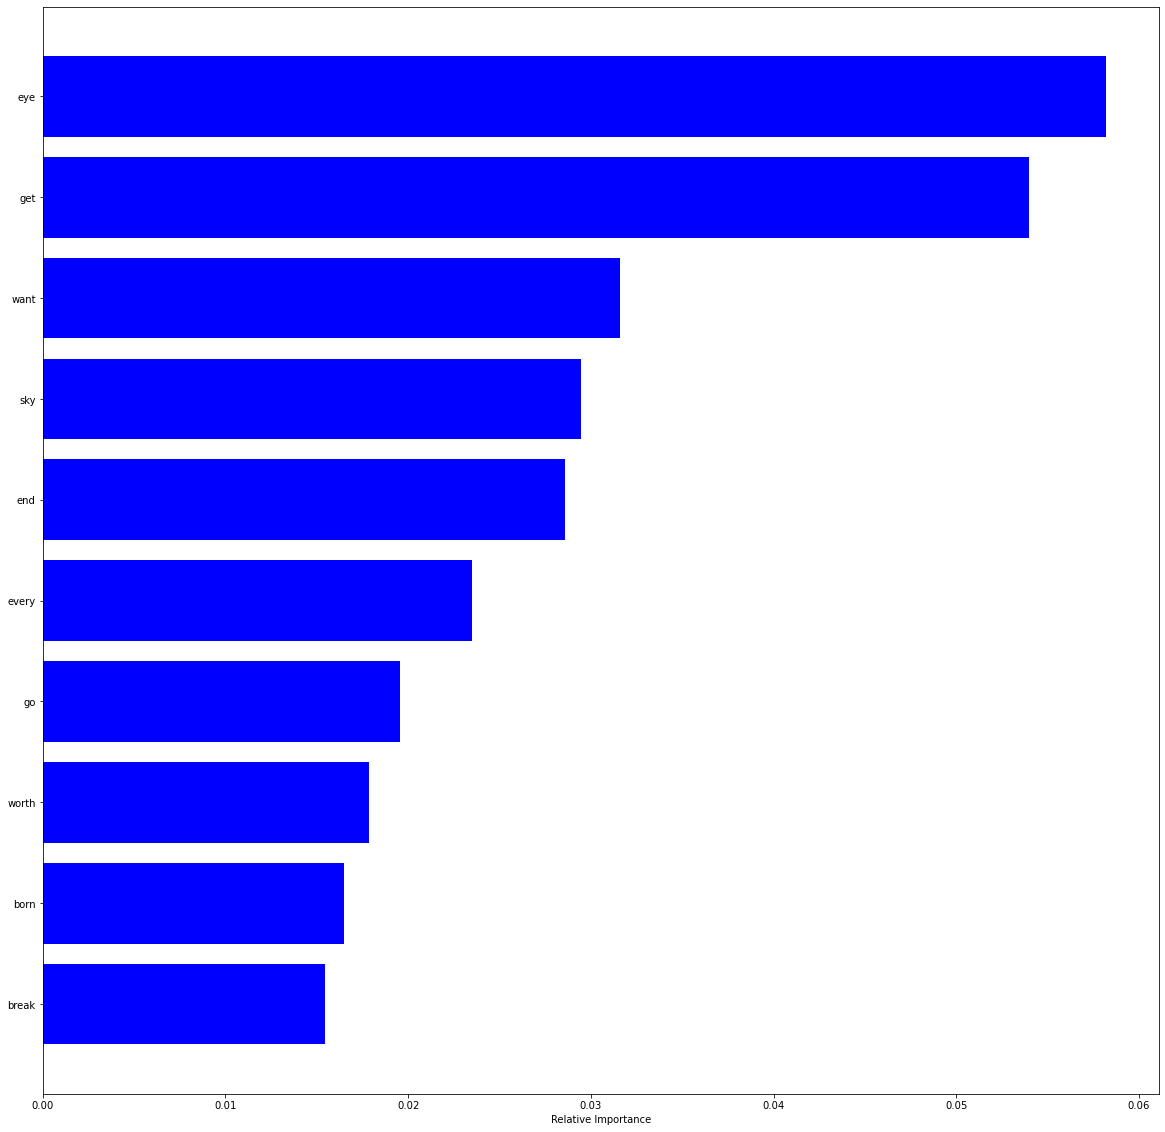

In [79]:
plot_feature_importances(rf_model_dict['popularity'])

**SGDRegressor**

In [41]:
sgd_model_dict = {}

for column in y_train:
    sgd = SGDRegressor()
    sgd_model_dict[column] = sgd
    print(f'{column} regression metrics:')
    single_reg(sgd, df_train, df_test, y_train[column], y_test[column])
    print('\n')

duration_ms regression metrics:
Train Root Mean Square Error: 34848.40397389726
Test Root Mean Square Error: 67137.45042442257


danceability regression metrics:
Train Root Mean Square Error: 0.12930829219840648
Test Root Mean Square Error: 0.14465507467038016


energy regression metrics:
Train Root Mean Square Error: 0.17655195620990116
Test Root Mean Square Error: 0.19987211383636186


key regression metrics:
Train Root Mean Square Error: 1.759142082106881
Test Root Mean Square Error: 3.5579227163185045


loudness regression metrics:
Train Root Mean Square Error: 1.573122232854033
Test Root Mean Square Error: 2.9241197065914304


speechiness regression metrics:
Train Root Mean Square Error: 0.05681549583549091
Test Root Mean Square Error: 0.05842743604803634


acousticness regression metrics:
Train Root Mean Square Error: 0.12061296943988996
Test Root Mean Square Error: 0.22882744473214672


instrumentalness regression metrics:
Train Root Mean Square Error: 0.1316111353841538
Test Ro

Out of all 4 models LassoLars and SGDRegressor preformed best. They showed less overfitting compared to the other two and had the lowest RMSE scores for popularity. The column 'duration_ms' has very high error in all models and will be dropped before hyperparameter tuning.

In [42]:
y_train = y_train.drop(columns=['duration_ms'], axis=1)
y_test = y_test.drop(columns=['duration_ms'], axis=1)

### Hyperparameter Tuning
Since there are mulitple y values that I am predicting, I will use gridsearch on the popularity column because that is the variable I want to more accurately predict.

#### SGDRegressor

In [79]:
dt_param_grid = {'loss': ['squared_loss','huber', 'epsilon_insensitive'],
                 'penalty': ['l2','l1','elasticnet'],
                 'max_iter': [1000, 2000, 2500]
}

dt_grid_search = GridSearchCV(sgd, dt_param_grid, cv=3, return_train_score=True)
dt_grid_search.fit(df_train, y_train['popularity'])

dt_grid_search.best_params_

{'loss': 'squared_loss', 'max_iter': 1000, 'penalty': 'l1'}

In [82]:
sgd_model_dict = {}

for column in y_train:
    sgd = SGDRegressor(loss='squared_loss', max_iter=1000, penalty='l1')
    sgd_model_dict[column] = sgd
    print(f'{column} regression metrics:')
    single_reg(sgd, df_train, df_test, y_train[column], y_test[column])
    print('\n')

danceability regression metrics:
Train Root Mean Square Error: 0.1298274235837293
Test Root Mean Square Error: 0.14455746789564078


energy regression metrics:
Train Root Mean Square Error: 0.17707568144146257
Test Root Mean Square Error: 0.20004670099615698


key regression metrics:
Train Root Mean Square Error: 1.7706030572579219
Test Root Mean Square Error: 3.558649873507205


loudness regression metrics:
Train Root Mean Square Error: 1.5866512252932734
Test Root Mean Square Error: 2.9236049993915443


speechiness regression metrics:
Train Root Mean Square Error: 0.05706543276650717
Test Root Mean Square Error: 0.058635575975921936


acousticness regression metrics:
Train Root Mean Square Error: 0.1208558484010537
Test Root Mean Square Error: 0.2289001200709901


instrumentalness regression metrics:
Train Root Mean Square Error: 0.1317430337159052
Test Root Mean Square Error: 0.13681017777677723


liveness regression metrics:
Train Root Mean Square Error: 0.11536808600235772
Test Ro

Comparing this model to the defualt SGDRegressor, this model gave a lot of the same values for RMSE. Popularity did not change much either, it went from 3.7868 train and 5.8559 test to 3.7926 train to 5.8538 test. I will use this model to make predicts on the generated lyrics.

In [83]:
for key in sgd_model_dict.keys():
    x = sgd_model_dict[key].predict(df_test)
    print(f'{key}: {x}')

danceability: [0.5046252  0.50916411 0.51674988 0.51653688 0.50070604 0.50667732
 0.52147647 0.51180306 0.50365451 0.50900027 0.51724007 0.50945284
 0.50014212 0.50722901 0.50275182 0.51400451 0.50762971 0.51470308
 0.51047446 0.51116067 0.50528086 0.50180005 0.51445633 0.51495721]
energy: [0.77235688 0.77781379 0.78734056 0.7887507  0.76738236 0.76933206
 0.79604271 0.78367758 0.76709328 0.77774465 0.7913534  0.78060657
 0.76463865 0.7817197  0.77207441 0.78089074 0.77455595 0.78370115
 0.78314304 0.7804013  0.77292711 0.76955901 0.79045851 0.78429288]
key: [4.80489147 5.32808893 3.9044289  4.37417291 4.96857985 4.94555786
 4.83736176 4.27531084 5.37494481 5.0959393  4.50760301 5.11888283
 5.08784543 4.52320476 5.84949864 5.45005038 5.24939648 5.30628008
 4.26940439 5.53494639 4.03622669 5.28070168 7.29446437 4.42313588]
loudness: [-5.19151013 -5.02620122 -6.17728169 -5.42441098 -5.21284156 -5.59709589
 -4.12755417 -4.46133392 -5.67853751 -4.87745956 -5.50579998 -5.68535863
 -5.589288

## Popularity Prediction

To run the generated song through the regression model, the lyrics need to be preprocessed the same way that the model was trained on.

In [84]:
def make_tokens(sentence_list):
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokens = []
    for sentence in range(len(sentence_list)):
        token = nltk.regexp_tokenize(sentence_list[sentence], pattern)
        tokens.append(token)
    
    corpus = []
    for i in range(len(tokens)):
        sentence = tokens[i]
        for x in range(len(sentence)):
            word = sentence[x]
            corpus.append(word)
    return corpus
            
def stopped_lyrics(tokens):
    stopped = [w for w in tokens if w not in stopwords_list and w not in ['na','la', 'nah', 'ah',
                                                                          'oh', "i'm","i've","i'll"]]
    return stopped

In [85]:
tokenized_song = make_tokens(new_song)
stopped_song = stopped_lyrics(tokenized_song)
stopped_song 

['kick',
 'face',
 'pop',
 "can't",
 'contain',
 "ain't",
 'okay',
 'snow',
 'mountains',
 "can't",
 'complain',
 'ones',
 'make',
 'world',
 'really',
 'find',
 'beautiful',
 'around',
 'wait',
 'baby',
 'oughta',
 'celebrate',
 "can't",
 'torture',
 'please',
 'forsake',
 'contagious',
 'fine',
 'okay',
 'stated',
 'sweep',
 'solitaire']

In [86]:
song_df = pd.DataFrame(data={'stopped_lyrics': [stopped_song]})
song_df

,stopped_lyrics
0,"[kick, face, pop, can't, contain, ain't, okay,..."


In [88]:
#using tfidf to transform song lyrics into matrix
song_vector = tfidf.transform(song_df)
song_vector.shape

(1, 3215)

In [89]:
vector_df = pd.DataFrame(song_vector.toarray(), columns=tfidf.get_feature_names())
vector_df

,aah,abandonment,abel,ability,aboard,abortion,absurd,acceleration,according,account,...,yet,yo,youembedshare,young,younger,zaniest,zapp,zodiac,zone,zulu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
song_dict = {}
for key in sgd_model_dict.keys():
    x = sgd_model_dict[key].predict(vector_df)
    song_dict[key] = x
song_dict

{'danceability': array([0.49149711]),
 'energy': array([0.75514128]),
 'key': array([4.84994425]),
 'loudness': array([-5.92016209]),
 'speechiness': array([0.05563902]),
 'acousticness': array([0.04493183]),
 'instrumentalness': array([0.03311858]),
 'liveness': array([0.15182843]),
 'valence': array([0.45210623]),
 'tempo': array([128.37707347]),
 'popularity': array([54.05544726])}

In [91]:
song_info = pd.DataFrame.from_dict(song_dict)
song_info

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity
0,0.491497,0.755141,4.849944,-5.920162,0.055639,0.044932,0.033119,0.151828,0.452106,128.377073,54.055447


## Conclusions
The generated lyrics would produce a song with a popularity score of 54.06.

## Next Steps
To improve upon this model, I want to try using pre-trained neural networks like textgenrnn to see if the model is better able to create longer text sequences. Adding layers and increasing the number of epochs could improve the current deep learning model. To improve this project in general, gathering additional data would help to reduce RMSE and create more accurate regression models along with more complex neural networks. 